# Introduction

There is an urge for data integration methods that enable to deal with heterogenous data. Regularised Generalised Canonical Correlation Analysis (RGCCA) is a privileged framework as it enables to explore linear relations between multiple blocks of data. With structured sparsity-inducing regularization it further allows to select coherent sets of variables to seek patterns of relevant features.

The multiblock module of the pylearn-parsimony library implements the method detailed in the paper [A general multiblock method for structured variable selection](https://arxiv.org/abs/1610.09490). In this tutorial we will briefly review the method and demonstrate how this module can be used with a practical example on the Glioma dataset.

# Glioma Data

This dataset is described in \cite{Cathy's Thesis}. It contains genetics information of tumors of 53 patients, with two different modalities: Gene expression (GE) and Comparative Genomic Hybridization (CGH) which respectively contain $p=4341$ and $q=1229$ features. For each patient, we further have the tumor location, a categorical variable with 3 different locations, encoded in a dummy matrix.

We wish to predict the tummor location, and investigate the relevant genes and pathways involved in this task.

In [1]:
import pandas as pd

In [2]:
data_dir = "./"    
data = pd.read_csv(data_dir + 'Data_Subset.csv').drop('Unnamed: 0', axis=1)
GE = data.loc[:,data.columns.str.startswith('GE')]
y = data.loc[:,data.columns[-3:]]
CGH = data.loc[:,data.columns.str.startswith('CGH')]

In [3]:
GE.head()

,GE.A_23_P109913,GE.A_24_P148717,GE.A_23_P250302,GE.A_23_P72989,GE.A_23_P412321,GE.A_24_P234921,GE.A_23_P343398,GE.A_23_P69012,GE.A_23_P407565,GE.A_23_P141367,...,GE.A_23_P1973,GE.A_23_P215419,GE.A_23_P259442,GE.A_32_P66804,GE.A_23_P304991,GE.A_23_P155351,GE.A_23_P61707,GE.A_23_P111826,GE.A_23_P361405,GE.A_23_P57927
0,-0.130073,-0.607874,0.071867,0.201223,-0.153277,0.720067,0.506888,0.180251,-0.333733,-0.952690,...,-3.383960,0.624622,-2.611288,-2.402020,1.533508,-0.180868,-0.317604,-0.037374,-1.033387,-0.298882
1,0.167522,0.934534,-0.389287,0.244923,0.600389,0.295036,0.026775,0.172103,2.876757,0.136076,...,-2.871910,-2.161968,-2.294974,-2.906984,0.537812,0.103850,2.397188,0.026909,-1.393335,0.569185
2,0.305580,0.643973,0.980439,-0.034889,0.061745,0.843857,1.442718,-0.112258,2.528982,-1.191226,...,-3.146454,-0.892187,-1.258385,-2.646591,1.311011,0.092064,-0.633101,-0.050350,-0.375389,0.795004
3,1.631464,0.833338,0.362822,0.009881,1.265838,0.493629,1.040985,0.475731,3.357208,-0.755619,...,-2.210552,-0.144747,-1.723304,-2.344496,0.699006,-0.310269,-0.836779,-0.107827,-0.978695,1.460305
4,0.935878,3.031405,0.522437,-0.107501,2.631120,0.684364,2.891547,0.325103,4.461593,-1.383289,...,-2.686294,-0.246895,-2.940980,-3.539916,0.035941,-0.432156,0.460132,-0.091937,-1.055290,0.350653


In [4]:
CGH.head()

,CGH.1,CGH.3,CGH.5,CGH.6,CGH.7,CGH.8,CGH.9,CGH.10,CGH.11,CGH.12,...,CGH.1386,CGH.1387,CGH.1388,CGH.1389,CGH.1390,CGH.1391,CGH.1392,CGH.1393,CGH.1396,CGH.1398
0,0.016823,0.016823,0.016823,0.016823,0.016823,0.016823,0.016823,0.016823,0.016823,0.016823,...,-0.014979,-0.014979,-0.014979,-0.014979,-0.014979,-0.014979,-0.014979,-0.014979,-0.014979,-0.014979
1,0.024953,0.024953,0.024953,0.024953,0.024953,0.024953,0.024953,0.024953,0.024953,0.024953,...,-0.175110,-0.175110,-0.175110,-0.175110,-0.175110,-0.175110,-0.175110,-0.175110,-0.175110,-0.175110
2,-0.362121,-0.362121,-0.362121,-0.362121,-0.362121,-0.362121,-0.362121,-0.362121,-0.362121,-0.362121,...,-0.046933,-0.046933,-0.046933,-0.046933,-0.046933,-0.046933,-0.046933,-0.046933,-0.046933,-0.046933
3,0.002180,0.002180,0.002180,0.002180,0.002180,0.002180,0.002180,0.002180,0.002180,0.002180,...,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226,0.003226
4,0.251068,0.251068,0.251068,0.251068,0.251068,0.251068,0.251068,0.251068,0.251068,0.251068,...,0.003202,0.003202,0.003202,0.003202,0.003202,0.003202,0.003202,0.003202,0.008779,0.008779


# The Model 

A first strategy could be to concatenate the data and use a classifier, like logistic regression. We evaluate this model with in a 5-fold crossvalidation scheme (note that a replication set would be necessary to validate these results but this is not the aim of this tutorial).

In [5]:
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [6]:
X = np.concatenate((GE.values, CGH.values), axis=1)
_, label = np.where(y == 1)

logreg = LogisticRegression()

In [7]:
cross_val_score(logreg, X, label, cv=5).mean()

0.7354545454545456

Let's now see if we can obtain better results by dealing with each block adequately, using RGCCA. We suppose no strong relation between the GE and CGH blocks, and investigate the relation between these two blocks and the location:

$$\max_{x,y,z} \;\; x^TX^TYy + z^TZ^TYy$$

With the following L1 and RGCCA constraints:
- $x \in \{ w \in \mathbb{R}^p, \;\; w^T ( \tau_{GE} I + (1- \tau_{GE} ) X^TX) w = 1 \;\; and \;\; \Vert w \Vert_1 \leq s_{GE} \} $
- $z \in \{w \in \mathbb{R}^q, \;\; w^T ( \tau_{CGH} I + (1- \tau_{CGH} ) Z^TZ) w = 1 \;\; and \;\; \Vert w \Vert_1 \leq s_{CGH}\}$
- $y \in \{w \in \mathbb{R}^3, \;\; \Vert w \Vert_2 = 1\}$

Where $\tau_{GE}, s_{GE}, \tau_{CGH}, s_{CGH}$ are regularization parameters.

Furthermore, we would like the genes to be selected to belong the same biological pathways, to reflect mechanism related to the tumor location, rather than single genes. For this purpose we use a network of gene interactions and add the GraphNet penalty to $x$:

$$ P(x) = \sum_{i,j} A_{ij} (x_i-x_j)^2 = x^TLx $$

where $A$ is the adjacency matrix of the graph, and $L$ its laplacian. For further details on the choise of penalties, see my report.

# The implementation

Let's now delve into the implementation of this model. The machinery in Parsimony is somewhat similar to Keras: we build an estimator function and add the covariance objectives to it (note that this is actually the opposite of the covariance, as a loss function to minimize instead of a objective to maximize):

In [8]:
import parsimony.functions.multiblock.losses as mb_losses

In [9]:
X1 = GE.values
X2 = CGH.values
n, p = GE.shape
_, q = CGH.shape

In [10]:
# instantiate the estimator
function = mb_losses.CombinedMultiblockFunction([X1,X2,y])

#define the covariance loss functions
cov_X1_y = mb_losses.LatentVariableCovariance([X1, y], unbiased=True)
cov_X2_y = mb_losses.LatentVariableCovariance([X2, y], unbiased=True)

#add them to the estimator, the arguments are the indices of the blocks it refers to in the list past when initializing
function.add_loss(cov_X1_y, 0, 2)
function.add_loss(cov_X2_y, 1, 2)

Then we add the constraints and penalties on each block loading. As in Witten 2009, we seek parameters $s_{GE}$ and $s_{CGH}$ between respectively $1/\sqrt{p}$ and $\sqrt{p}$, and $1/\sqrt{q}$ and $\sqrt{q}$. So we parametrise them by $l_1 *  \sqrt{p}$ and $l_2 * \sqrt{q}$.

In [11]:
import parsimony.functions.penalties as penalties

In [43]:
l1 = 0.3
l2 = 0.5
g2 = 1e-5
tau_1 = 1
tau_2 = 0.7

In [44]:
#Define the constraints
constraint1_L1 = penalties.L1(c=l1 * np.sqrt(p))
constraint2_L1 = penalties.L1(c=l2 * np.sqrt(q))
constraint1_L2 = penalties.RGCCAConstraint(c=1.0, tau=tau_1, X=X1)
constraint2_L2 = penalties.RGCCAConstraint(c=1.0, tau=tau_2, X=X2)
constraint3 = penalties.L2(c=1.0)

#add them to the estimator, giving the indice of the block it refers to
function.add_constraint(constraint1_L1, 0)
function.add_constraint(constraint1_L2, 0)
function.add_constraint(constraint2_L1, 1)
function.add_constraint(constraint2_L2, 1)
function.add_constraint(constraint3, 2)

And finally add the GraphNet penalty, as a penalty with a multiplier g2 (instead of a contraint) and Laplacian L:

In [45]:
from scipy.io import mmread
from scipy.sparse import csgraph

In [46]:
adj = mmread(data_dir + './Kegg_Graph.txt').tocsr()
L = csgraph.laplacian(adj)

In [47]:
GraphNet = penalties.GraphNet(l=g2, A=L)
function.add_penalty(GraphNet, 0)

We can now initialize the loadings $x,z,y$ for fitting:

In [48]:
import parsimony.utils.weights as start_vectors

In [49]:
random_vector = start_vectors.RandomUniformWeights(normalise=False)
x = random_vector.get_weights(p)
z = random_vector.get_weights(q)
t = random_vector.get_weights(y.shape[1])
w = [x,z,t]

To fit this model to the data, we use a block iteration scheme (similar to block coordinate descent), that is, we iterate over the blocks and minimize the loss function with respect to each loading vector whilst keeping others fixed. For the minimization of each subproblem, we use Fista. This is described more in depth in the paper. All we need to do here is to initialize the algorithm with a few parameters:

- eps is the desired convergence precision
- max_inner_iter is the maximum number of iteration for Fista in each subproblem minimization. It is in fact not necessary to go all the way to convergence, but only a few iterations are enough to reach global convergence (although this result is empirical)
- max_outer_iter is the maximu number of iterations through the blocks
- steps is a list of steps to be used for each block in Fista

In [50]:
import parsimony.algorithms.multiblock as algorithms

The step should be fixed according to the inverse Lipschitz constant of the gradient, however here, in the absence of penalty, the gradients according to $x,z,y$ are constants wrt $x,z,y$ respectively, we thus fix a small step size:

In [51]:
steps = [0.05] * 3

We then define a few callbacks that we wish to save during the optimization:

In [52]:
from parsimony.algorithms.utils import Info
info = [Info.num_iter,Info.converged,Info.func_val]

In [53]:
algorithm = algorithms.MultiblockFISTA(eps=5e-14, info=info, 
                                        max_inner_iter=20,
                                        max_outer_iter=80,
                                        steps=steps)

We can now run the algorithm, retrieve the information, and plot the resulting weights:

In [54]:
w = algorithm.run(function, w)
infos = algorithm.info_get()

In [55]:
import matplotlib.pyplot as plt
% matplotlib inline

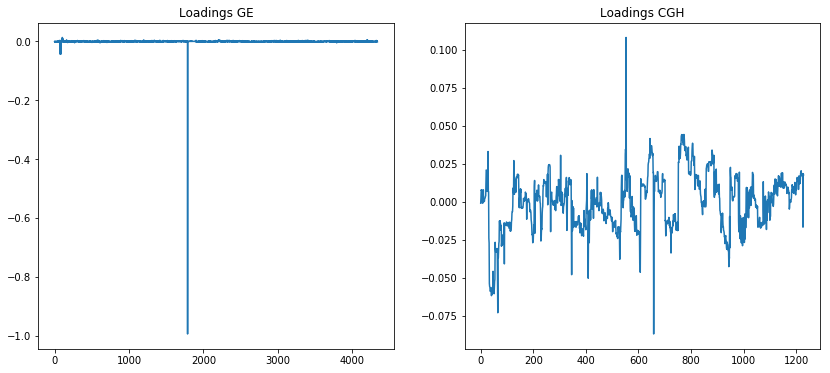

In [56]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(w[0])
plt.title('Loadings GE')
plt.subplot(122)
plt.plot(w[1])
plt.title('Loadings CGH');

To solve our initial classification task, we use the score vectors as features in a Linear Discriminant Analysis (LDA):

In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [58]:
lda = LinearDiscriminantAnalysis()
t1 = np.dot(X1, w[0])
t2 = np.dot(X2, w[1])
predictors = np.concatenate([t1,t2], axis=1)

cross_val_score(lda, predictors, label, cv=5).mean()

0.5124242424242424

# The full pipeline

We however need to standardize the data first. Further, to properly evaluate this model, we need to gridsearch the hyper parameters in a cross-validation scheme. For that purpose, we define the previous model in an object, which inherits the basic properties of scikit-learn transformers and use the corresponding GridSearch function.

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer

In [60]:
class GraphNetCCA(BaseEstimator, TransformerMixin):
    """ an object that does all the magic described above, compatible with scikit-learn model selection pipeline
    """
    
    def __init__(self, p, q, L, l1=1, l2=1, g2=0.01, init='svd', eps=5e-14, max_block_iter=10,
                 max_inner_iter=1000, standardize_dummy=True, tau=[1,1,0], steps='fixed'):

        self.l1 = l1
        self.l2 = l2
        self.g2 = g2
        self.L = L
        self.init = init
        self.steps = steps
        self.p = p
        self.q = q
        self.tau = tau
        self.standardize_dummy = standardize_dummy
        self.max_block_iter = max_block_iter
        self.max_inner_iter = max_inner_iter
        self.eps = eps

    def fit(self, X, y):
        
        X1 = X[:,:self.p]
        X2 = X[:,self.p:self.p + self.q]
        self.g2 = 10 ** (self.g2)
        
        #compute dummy matrix from label vector
        self.lb = LabelBinarizer()
        y_ = self.lb.fit_transform(y).astype(np.float64)
        if self.standardize_dummy:
            y_ -= np.mean(y_, axis=0)
            y_ /= np.std(y_, axis=0)
    
        if self.init == 'svd':
            V_1,S_1,U_1 = np.linalg.svd(X1.T,full_matrices=0)
            V_2,S_2,U_2 = np.linalg.svd(X2.T,full_matrices=0)
            V_3,S_3,U_3 = np.linalg.svd(y_.T,full_matrices=0)
            x = V_1.T[0,:].reshape((X1.shape[1],1))
            z = V_2.T[0,:].reshape((X2.shape[1],1))
            t = V_3.T[0,:].reshape((y_.shape[1],1))
        
        if self.steps == 'fixed':
            steps = [0.005] * 3
        
        elif self.steps == 'svd' and self.init == 'svd':
            steps = [1 / S_1[0], 1 / S_2[0], 1 / S_3[0]]
        
        elif isinstance(self.steps, list):
            if len(self.steps) == 3:
                steps = self.steps
    
        elif self.init == 'random':
            random_vector = start_vectors.RandomUniformWeights(normalise=False)
            x = random_vector.get_weights(X1.shape[1])
            z = random_vector.get_weights(X2.shape[1])
            t = random_vector.get_weights(y_.shape[1])
    
        constraint1_L1 = penalties.L1(c=self.l1 * np.sqrt(self.p))
        constraint2_L1 = penalties.L1(c=self.l2 * np.sqrt(self.q))
        constraint1_L2 = penalties.RGCCAConstraint(c=1.0, tau=self.tau[0], X=X1)
        constraint2_L2 = penalties.RGCCAConstraint(c=1.0, tau=self.tau[1], X=X2)
        constraint3 = penalties.L2(c=1.0)
        GraphNet = penalties.GraphNet(l=self.g2, A=self.L)
    
        cov_X1_y = mb_losses.LatentVariableCovariance([X1, y_], unbiased=True)
        cov_X2_y = mb_losses.LatentVariableCovariance([X2, y_], unbiased=True)
        
        function = mb_losses.CombinedMultiblockFunction([X1,X2,y_])
        function.add_loss(cov_X1_y, 0, 2)
        function.add_loss(cov_X2_y, 1, 2)
        function.add_constraint(constraint1_L1, 0)
        function.add_constraint(constraint1_L2, 0)
        function.add_constraint(constraint2_L1, 1)
        function.add_constraint(constraint2_L2, 1)
        function.add_constraint(constraint3, 2)
        function.add_penalty(GraphNet, 0)
        info = [Info.num_iter,Info.converged,Info.func_val]
        w = [x, z, t]
        f = [function.f(w)]
        
        self.algorithm = algorithms.MultiblockFISTA(eps=self.eps, info=info, 
                                              max_inner_iter=self.max_inner_iter,
                                              max_outer_iter=self.max_block_iter,
                                              steps=steps)
                                              
        self.w = self.algorithm.run(function, w)
        self.infos = self.algorithm.info_get()
        f += [-g for g in self.infos['func_val']]
        self.fval = np.array(f).ravel()
        
        return self

    def transform(self,X, y=None):
        
        X1 = X[:,:self.p]
        X2 = X[:,self.p:self.p + self.q]
        t1 = np.dot(X1, self.w[0])
        t2 = np.dot(X2, self.w[1])

        return np.concatenate([t1, t2], axis=1)

We can now use this estimator in a pipeline and test many parameters in a 5-fold cross-validation scheme.

In [61]:
from scipy.stats import uniform, randint
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [62]:
psq = 1 / np.sqrt(p)
qsq = 1 / np.sqrt(q)

param_dist = {'graphnetcca__l1': uniform(loc=psq ,scale=0.8-psq),
              'graphnetcca__l2': uniform(loc=qsq,scale=0.8-qsq),
              'graphnetcca__g2': randint(low=-8, high=-1)}

pipeline = make_pipeline(StandardScaler(),
                         GraphNetCCA(p=p, q=q, L=L, tau=[1,0.8], max_block_iter=100,
                                     max_inner_iter=20, steps='svd'),
                         LinearDiscriminantAnalysis())

n_iter_search = 1
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist,
                               n_iter=n_iter_search, verbose=2, cv=5,
                               n_jobs=3, return_train_score=True)

random_search.fit(X, label)

results = pd.DataFrame(random_search.cv_results_)
results.to_csv(data_dir + 'Glioma_Search.csv')

np.save(data_dir + 'best_estimator_Glioma_Search', random_search.best_estimator_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] graphnetcca__g2=-2, graphnetcca__l1=0.4270697396244363, graphnetcca__l2=0.27616299834709224 
[CV] graphnetcca__g2=-2, graphnetcca__l1=0.4270697396244363, graphnetcca__l2=0.27616299834709224 
[CV] graphnetcca__g2=-2, graphnetcca__l1=0.4270697396244363, graphnetcca__l2=0.27616299834709224 
[CV] graphnetcca__g2=-2, graphnetcca__l1=0.4270697396244363, graphnetcca__l2=0.27616299834709224 
[CV] graphnetcca__g2=-2, graphnetcca__l1=0.4270697396244363, graphnetcca__l2=0.27616299834709224 


KeyboardInterrupt: 